In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 
import warnings
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv("Daily_all.csv", index_col = "date")

In [29]:
test_size = 30
split_point = int(df.shape[0]-test_size)

In [30]:
df_train = df.iloc[0:split_point,:]
df_test = df.iloc[split_point:df.shape[0],:]

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [32]:
df_train.head()

,quantity
date,
2019-06-01,136
2019-06-02,5
2019-06-03,30
2019-06-04,2146
2019-06-05,2066


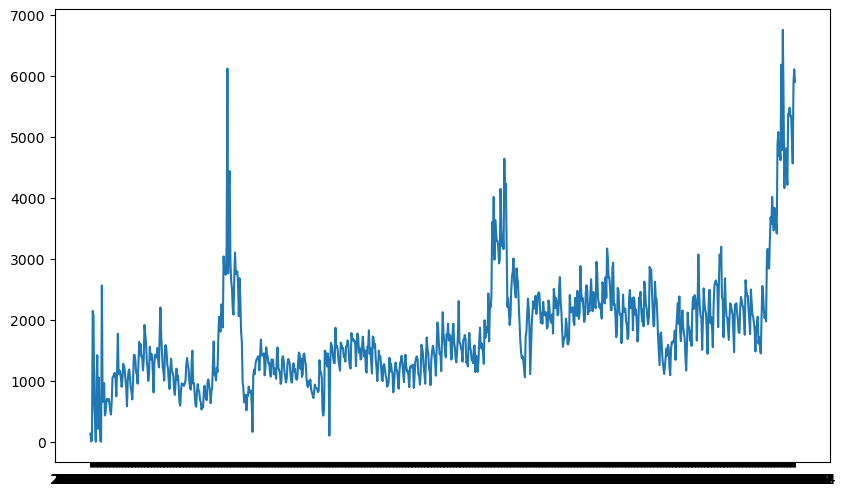

In [33]:
plt.figure(figsize=(10,6), dpi=100)
plt.locator_params(axis="x",nbins=10)
plt.plot(df_train)

plt.show()

In [34]:
def ADF_Stationarity_Test(timeseries, significance_level = 0.05):
    """
    Test if series is stationary given a time-series object and a seignificance level
    """
    X = timeseries.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1]<significance_level:
        print(f"Rejected null hypothesis at {round(significance_level,2)}% significance level. The test found evidence of stationarity")
    else:
        print(f"Failed to reject null hypothesis at {round(significance_level,2)}% significance level. No evidence of stationarity")

In [35]:
ADF_Stationarity_Test(df_train)

ADF Statistic: -1.823014
p-value: 0.369097
Failed to reject null hypothesis at 0.05% significance level. No evidence of stationarity


The test indicates it is not stationary, (sales increased over time). Let's check the difference with first lag.

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

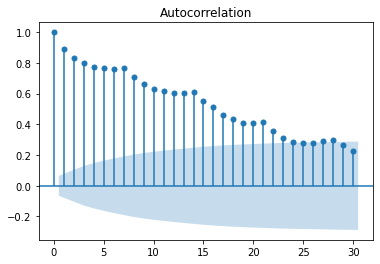

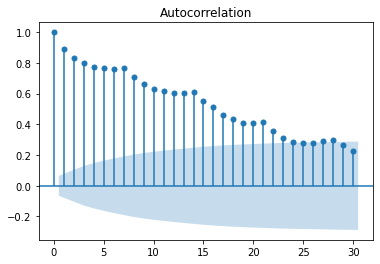

In [37]:
plot_acf(df_train) #in the raw series correlation up to the 28th lag

In [38]:
#Getting the difference series (t - (t-1))
X = df_train - df_train.shift(1)
X = X.dropna()

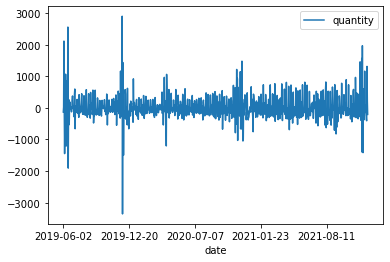

In [39]:
X.plot();

Looks much better and it seems to be stationary

In [40]:
ADF_Stationarity_Test(X)

ADF Statistic: -6.257987
p-value: 0.000000
Rejected null hypothesis at 0.05% significance level. The test found evidence of stationarity


Stationarity confirmed by the test

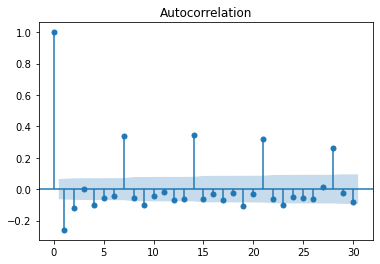

In [41]:
plot_acf(X)
plt.show()

When the difference to the 1st lag is applied autocorrelation seems to go up to the 2nd lag, so a AR(1) will be used with I(1)

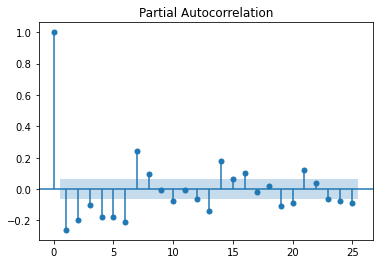

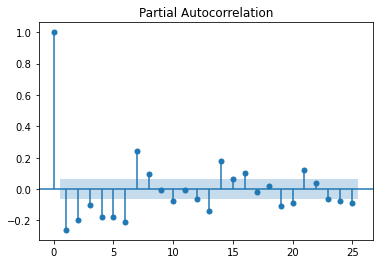

In [42]:
plot_pacf(X, lags=25)

The pacf plot suggests the MA(8). 
We will start with ARIMA(2,1,8).

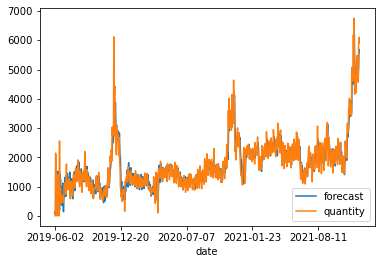

In [43]:
# fit model
model = ARIMA(df_train, order=(2,1,8))
results = model.fit()
results.plot_predict(dynamic=False)
plt.show()

In [18]:
prediction = results.forecast(30)

In [19]:
df_train.tail

<bound method NDFrame.tail of             quantity
date                
2019-06-01       136
2019-06-02         5
2019-06-03        30
2019-06-04      2146
2019-06-05      2066
...              ...
2021-12-10      4969
2021-12-11      4562
2021-12-12      5877
2021-12-13      6103
2021-12-14      5898

[927 rows x 1 columns]>

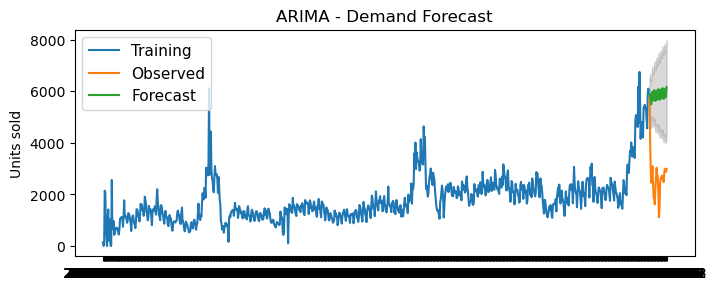

In [44]:
# Forecast
pred, se, conf = results.forecast(30, alpha=0.05)
Forecast = pd.Series(pred, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(8,3), dpi=100)
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Observed')
plt.plot(Forecast, label='Forecast')
plt.ylabel('Units sold')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA - Demand Forecast')
plt.legend(loc='upper left', fontsize=11)
plt.show()

My interpretation of it is that this model is not reasonable to predict 30 days ahead for this kind of series, so I will try other models.

In [23]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

In [24]:
mean_absolute_percentage_error(df_test, Forecast)

1.4030556274669128

In [25]:
mean_absolute_error(df_test, Forecast)

3202.690833198678

In [26]:
mean_squared_error(df_test, Forecast)

10924037.450565457

# Auto-arima test

Attempted to model using auto_arima, but still the model did not capture the decrease in demand caracteristic of the series

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
arima_model = auto_arima(df_train)

In [ ]:
arima_model.summary()

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 30), index=df_test.index)
prediction.columns = ['Predicted Demand']